In [2]:
#These were the libraies imported for use for the project.
import numpy as np 
import pandas as pd 
import os
import glob
from tqdm import tqdm
from time import sleep
from tabulate import tabulate
import matplotlib.pyplot as plt
import librosa as lib
import IPython.display as ipd
from pathlib import PurePosixPath, PureWindowsPath, WindowsPath
import pathlib
import tensorflow as tf
from sklearn.model_selection import train_test_split
import shutil
import soundfile
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from nltk.tokenize import word_tokenize
import re
from langdetect import detect
from sklearn.metrics import accuracy_score
from tensorflow.keras import models
from tensorflow.keras import layers
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, TimeDistributed
import Levenshtein as lev
import openpyxl

2024-04-28 10:21:36.963761: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# This should correspond to the path where augmentation or any other additional file or folder generation takes place so as to
# avoid unnecessary changes to dataset which can affect future use of dataset
# you can save data samples on any your computer, in this case it was saved on the Desktop folder on a unix system, 
# Paths style or formating on windows system is going to differ, take that into consideration
# Windows Path Style: file_path = "C:\\Users\\Username\\Documents\\file.txt" or
# file_path = os.path.join("C:", "Users", "Username", "Documents", "file.txt")

dir = 'Add_path_to_Computer_root_dir/Desktop/UG/' #eg: Users/Ama_MacBook/Desktop/UG

# Assign directory
#This should correspond to the path where the dataset sits for reliable and accurate access
directory = dir+'UGSPEECHDATA/' 


# Defined column names in dataset corresponding to the excel sheet containing or transcribed audios (order doesn't matter),
# It was reference here to be use to execute a data normalization/cleaning later on in the course of project. This was neccessary because of
# the non-uniform naming of the columns between at least more than one of the languages selected transcribed audio file
target_column_names = ['FILE_NO.', 'IMAGE_PATH', 'IMAGE_SRC_URL', 'AUDIO_PATH', 'TRANSCRIPTION',
                       'SPEAKER_ID','ORG_NAME', 'PROJECT_NAME', 'LOCALE', 'GENDER', 'AGE',
                       'DEVICE', 'ENVIRONMENT', 'YEAR','FULL_FILENAME', 'FILENAME']

#This was used for data visualization purposes to label each of the langauges
locale = ['ak_gh', 'dga_gh', 'dag_gh', 'ee_gh', 'kpo_gh'] 

#excel file for use
# vital for the merging of all five langauges selected transcribed audio as one single dataframe(rown and columns datatype from the pandas library)
target_excel = '/selected transcribed audios/selected transcribed audios.xlsx'


In [98]:
# Iterate over folder for transcriped audio file in directory
def get_transcribed_files():
    fileList = []
    for name in os.listdir(directory):
        if not name.__contains__("."):
          #
          fileList.append(os.path.join(directory, name)+target_excel)
            
          #Prints directory folder names corresponding to languages 
          #print(os.path.join(name))
    return fileList

In [99]:
# Reads excel data and store as dataframe
def read_data_excel(url):
    df = pd.read_excel(url, index_col=0, keep_default_na=False, na_values='')
    return df

In [100]:
# Cleanup column names for consolidation of languages and their coresponding data 
mapper = {}

def format_column_names(dataframe):
    for col_name in dataframe.columns:
        for target_name in target_column_names:
            #
            df_column_for_compare = col_name.lower().strip().replace(' ', '_').removesuffix('2').removesuffix('s')
            target_column_for_compare = target_name.lower().strip().replace(' ', '_').removesuffix('2').removesuffix('s')
    
            if df_column_for_compare == target_column_for_compare:
                mapper[col_name] = target_name
                break
    
    # Rename the columns
    dataframe = dataframe.rename(columns=mapper)
    
    return dataframe
    

In [101]:
# declares and initiates and empty list to store all consolidated languages excel data
frame = []
fileList = get_transcribed_files() # gets all selected transcribed audio excel file

def consolidate_lang_datas():
    
  for file in tqdm(fileList):
      df = read_data_excel(file) #read data from excel sheet
      df = format_column_names(df)
      frame.append(df) # append each new sheet as a value in the frame list
  #    
  print('Completed')

#
consolidate_lang_datas() # call function for the frame list to be initialized

100%|█████████████████████████████████████████████| 5/5 [00:27<00:00,  5.45s/it]

Completed


In [102]:
# Returns frame length
len(frame) 

5

In [228]:
#Print fileList involved in the creation of the frame
fileList

In [104]:
#First three entries in Frame 1   
frame[0].head(3)

IMAGE_PATH  \
unamed                          
700     Ikposo/images/0001jpg   
741     Ikposo/images/0001jpg   
1379    Ikposo/images/0001jpg   

                                            IMAGE_SRC_URL  \
unamed                                                      
700     https://livestaticflickrcom/7846/46666781031_3...   
741     https://livestaticflickrcom/7846/46666781031_3...   
1379    https://livestaticflickrcom/7846/46666781031_3...   

                                               AUDIO_PATH  \
unamed                                                      
700     Ikposo\selected transcribed audios\audios\kpo_...   
741     Ikposo\selected transcribed audios\audios\kpo_...   
1379    Ikposo\selected transcribed audios\audios\kpo_...   

                                            TRANSCRIPTION  \
unamed                                                      
700     Ake kele iku nʋ ɛvɛ : ɔlɔdɩ eku k'adʋɩ nʋ olʋk...   
741     Akekele iikukuu aluu duu ikuɖʒaɛ namu aluagaga...   
1379    alò ɔbu eku alɛ ɛdini adu awu wɛ uvi edigbo ez...   

                   ORG_NAME PROJECT_NAME  SPEAKER_ID  LOCALE  GENDER  AGE  \
unamed                                                                      
700     University of Ghana        Waxal        5154  kpo_gh  Female   45   
741     University of Ghana        Waxal        4008  kpo_gh  Female   36   
1379    University of Ghana        Waxal        4809  kpo_gh  Female   49   

                                DEVICE ENVIRONMENT  YEAR  \
unamed                                                     
700                    samsung SM-X205     Outdoor  2024   
741     TECNO MOBILE LIMITED TECNO KB8     Outdoor  2023   
1379    TECNO MOBILE LIMITED TECNO KC8      Indoor  2024   

                                     FULL_FILENAME  
unamed                                              
700     kpo_gh_image_0001_u647_1_1682155905824.mp3  
741     kpo_gh_image_0001_u102_1_1679692626635.mp3  
1379    kpo_gh_image_0001_u173_1_1681643753002.mp3

In [105]:
#First three entries in Frame 2
frame[1].head(3)

IMAGE_PATH FILE_NO.  \
unamed                                 
1       Ewe/images/0002.jpg    00004   
2       Ewe/images/0009.jpg    00017   
3       Ewe/images/0008.jpg    00015   

                                            IMAGE_SRC_URL  \
unamed                                                      
1       https://c8.alamy.com/zooms/9/e614f7b88cf64ba48...   
2       https://totalenergies.com/sites/g/files/nytnzq...   
3                https://images.mktw.net/im-537576/social   

                                               AUDIO_PATH  \
unamed                                                      
1       Ewe\selected transcribed audios\audios\ee_gh_i...   
2       Ewe\selected transcribed audios\audios\ee_gh_i...   
3       Ewe\selected transcribed audios\audios\ee_gh_i...   

                                            TRANSCRIPTION  SPEAKER_ID  \
unamed                                                                  
1       E3umidzra5e le m4 to. Ame a2ewo t4 2e em4 to. ...          12   
2        ~utsu et-wo le mashinid4w45e le d4 w4m, wo do...          11   
3        @evi a2ewo kple ny4nu a2e n4 se5o5o nyui a2ew...          13   

                   ORG_NAME PROJECT_NAME LOCALE  GENDER  AGE  \
unamed                                                         
1       University of Ghana        Waxal  ee_gh    Male   38   
2       University of Ghana        Waxal  ee_gh  Female   30   
3       University of Ghana        Waxal  ee_gh    Male   22   

                                       DEVICE ENVIRONMENT  YEAR  \
unamed                                                            
1                             HUAWEI TRT-L21A      Indoor  2023   
2       INFINIX MOBILITY LIMITED Infinix X604      Indoor  2023   
3             TECNO MOBILE LIMITED TECNO BD4j      Indoor  2023   

                                         FULL_FILENAME  \
unamed                                                   
1       ee_gh_image_0002_u51_1_1687340431752_00004.mp3   
2       ee_gh_image_0009_u48_1_1687340346811_00017.mp3   
3       ee_gh_image_0008_u45_1_1687332952541_00015.mp3   

                                        FILENAME  
unamed                                            
1       ee_gh_image_0002_u51_1_1687340431752.mp3  
2       ee_gh_image_0009_u48_1_1687340346811.mp3  
3       ee_gh_image_0008_u45_1_1687332952541.mp3

In [106]:
#First three entries in Frame 3
frame[2].head(3)

FILE_NO.               IMAGE_PATH  \
unamed                                      
11169      12153  Dagbani/images/0692.jpg   
6380        6838  Dagbani/images/0795.jpg   
1519        1540  Dagbani/images/0874.jpg   

                                            IMAGE_SRC_URL  \
unamed                                                      
11169   https://api.openverse.engineering/v1/images/49...   
6380    https://images.pexels.com/photos/279648/pexels...   
1519    https://i.pinimg.com/564x/0b/25/17/0b2517c7de6...   

                                               AUDIO_PATH  \
unamed                                                      
11169   Dagbani\selected transcribed audios\audios\dga...   
6380    Dagbani\selected transcribed audios\audios\dga...   
1519    Dagbani\selected transcribed audios\audios\dga...   

                                            TRANSCRIPTION  \
unamed                                                      
11169   "Airport" m-bɔŋɔ ka niriba pam be di puuni ka ...   
6380    "Dinning" ni m-bɔŋɔ duɣili shee ka kuɣisi ʒeya...   
1519    "Laboratory" ni puuni ka n-nyɛ o ka silimiin'd...   

                   ORG_NAME PROJECT_NAME  SPEAKER_ID  LOCALE GENDER  AGE  \
unamed                                                                     
11169   University of Ghana        Waxal        3488  dga_gh   Male   25   
6380    University of Ghana        Waxal        3488  dga_gh   Male   25   
1519    University of Ghana        Waxal        3503  dga_gh   Male   28   

                 DEVICE ENVIRONMENT  YEAR  \
unamed                                      
11169   samsung SM-X205      Indoor  2023   
6380    samsung SM-X205      Indoor  2023   
1519    samsung SM-X205     Outdoor  2023   

                                            FILENAME  \
unamed                                                 
11169   dga_gh_image_0692_u12425_1_1679048840716.mp3   
6380    dga_gh_image_0795_u14216_1_1679049286156.mp3   
1519    dga_gh_image_0874_u15636_1_1679062588255.mp3   

                                            FULL_FILENAME  
unamed                                                     
11169   dga_gh_image_0692_u12425_1_1679048840716_12153...  
6380    dga_gh_image_0795_u14216_1_1679049286156_06838...  
1519    dga_gh_image_0874_u15636_1_1679062588255_01540...

In [107]:
#First three entries in Frame 4
frame[3].head(3)

FILE_NO.               IMAGE_PATH  \
unamed                                      
1             52  Dagaare/images/0012.jpg   
2             64  Dagaare/images/0018.jpg   
3            663  Dagaare/images/0001.jpg   

                                            IMAGE_SRC_URL  \
unamed                                                      
1       https://c8.alamy.com/comp/DKAXR5/woman-prepari...   
2           https://etimg.etb2bimg.com/photo/89133443.cms   
3       https://live.staticflickr.com/7846/46666781031...   

                                               AUDIO_PATH  \
unamed                                                      
1       Dagaare\selected transcribed audios\audios\dag...   
2       Dagaare\selected transcribed audios\audios\dag...   
3       Dagaare\selected transcribed audios\audios\dag...   

                                            TRANSCRIPTION  \
unamed                                                      
1        Bondiiri la ka pɔge kaŋa zeŋ daaŋaa muniŋ, a ...   
2        Lɔpeɛlaa ne lɔ-zeɛ ahe peɛlɛɛ taa ka a nimbit...   
3        Dɔbɔ ne pɔgebɔ a zeŋ, ka kaŋa gbi a puoro kaŋ...   

                   ORG_NAME PROJECT_NAME  SPEAKER_ID  LOCALE  GENDER  AGE  \
unamed                                                                      
1       University of Ghana        Waxal         162  dag_gh    Male   30   
2       University of Ghana        Waxal         129  dag_gh    Male   25   
3       University of Ghana        Waxal        1312  dag_gh  Female   29   

                                        DEVICE ENVIRONMENT  YEAR  \
unamed                                                             
1               TECNO MOBILE LIMITED TECNO LA7     Outdoor  2023   
2       INFINIX MOBILITY LIMITED Infinix X655C      Indoor  2023   
3       INFINIX MOBILITY LIMITED Infinix X688B     Outdoor  2023   

                                           FILENAME  \
unamed                                                
1        dag_gh_image_0012_u559_1_1690263050340.mp3   
2        dag_gh_image_0018_u556_1_1690243430477.mp3   
3       dag_gh_image_0001_u2773_1_1693771979621.mp3   

                                            FULL_FILENAME  
unamed                                                     
1        dag_gh_image_0012_u559_1_1690263050340_00052.mp3  
2        dag_gh_image_0018_u556_1_1690243430477_00064.mp3  
3       dag_gh_image_0001_u2773_1_1693771979621_00663.mp3

In [108]:
#First three entries in Frame 5
frame[4].head(3)

FILE_NO.            IMAGE_PATH  \
unamed                                   
723         1234  Akan/images/0152.jpg   
2582        7483  Akan/images/0135.jpg   
2564        7573  Akan/images/0159.jpg   

                                            IMAGE_SRC_URL   AUDIO_PATH  \
unamed                                                                   
723     https://i.pinimg.com/474x/12/63/89/12638935862...  A_01234.mp3   
2582    https://i.pinimg.com/474x/35/e6/2e/35e62eba6e0...  A_07483.mp3   
2564    https://i.pinimg.com/564x/88/b2/8b/88b28bbfba8...  A_07573.mp3   

                                            TRANSCRIPTION  SPEAKER_ID  \
unamed                                                                  
723     Ↄbaa no de kente no asiesie ne ho. Ↄde kente n...        4384   
2582    Mmɔfra ɛnson ɛɛdware ɛwɔ nsutene mu. Mmɔfra yi...        4384   
2564    Abaamua ɛso kɛntɛn a ɛnneɛma ɛgu mu ma ɛde nam...        4384   

                   ORG_NAME PROJECT_NAME LOCALE  GENDER  AGE  \
unamed                                                         
723     University of Ghana        Waxal  ak_gh  Female   25   
2582    University of Ghana        Waxal  ak_gh  Female   25   
2564    University of Ghana        Waxal  ak_gh  Female   25   

                                       DEVICE ENVIRONMENT  YEAR  \
unamed                                                            
723     INFINIX MOBILITY LIMITED Infinix X690      Indoor  2023   
2582    INFINIX MOBILITY LIMITED Infinix X690      Indoor  2023   
2564    INFINIX MOBILITY LIMITED Infinix X690      Indoor  2023   

                                            FULL_FILENAME  \
unamed                                                      
723     ak_gh_image_0152_u238_1_1679831446914_KwhUHpA_...   
2582    ak_gh_image_0135_u238_1_1679865062058_Ky1MX8A_...   
2564    ak_gh_image_0159_u238_1_1679843265789_sxMkpPA_...   

                                                 FILENAME  
unamed                                                     
723     ak_gh_image_0152_u238_1_1679831446914_KwhUHpA.mp3  
2582    ak_gh_image_0135_u238_1_1679865062058_Ky1MX8A.mp3  
2564    ak_gh_image_0159_u238_1_1679843265789_sxMkpPA.mp3

In [109]:
#combine all dataframes in frame as a single dataframe for processing
df_combined = pd.concat(frame, join='outer')

In [110]:
#Structure of dataframe 1 in frame, corresponds to index 0
frame[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 18175 entries, 700 to 14624
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   IMAGE_PATH     18175 non-null  object
 1   IMAGE_SRC_URL  18175 non-null  object
 2   AUDIO_PATH     18175 non-null  object
 3   TRANSCRIPTION  18175 non-null  object
 4   ORG_NAME       18175 non-null  object
 5   PROJECT_NAME   18175 non-null  object
 6   SPEAKER_ID     18175 non-null  int64 
 7   LOCALE         18175 non-null  object
 8   GENDER         18175 non-null  object
 9   AGE            18175 non-null  int64 
 10  DEVICE         18175 non-null  object
 11  ENVIRONMENT    18175 non-null  object
 12  YEAR           18175 non-null  int64 
 13  FULL_FILENAME  18175 non-null  object
dtypes: int64(3), object(11)
memory usage: 2.1+ MB


In [111]:
#Structure of dataframe 4 in frame, corresponds to index 3
frame[3].info()

<class 'pandas.core.frame.DataFrame'>
Index: 18954 entries, 1 to 16524
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   FILE_NO.       18954 non-null  int64 
 1   IMAGE_PATH     18954 non-null  object
 2   IMAGE_SRC_URL  18954 non-null  object
 3   AUDIO_PATH     18954 non-null  object
 4   TRANSCRIPTION  18954 non-null  object
 5   ORG_NAME       18954 non-null  object
 6   PROJECT_NAME   18954 non-null  object
 7   SPEAKER_ID     18954 non-null  int64 
 8   LOCALE         18954 non-null  object
 9   GENDER         18954 non-null  object
 10  AGE            18954 non-null  int64 
 11  DEVICE         18954 non-null  object
 12  ENVIRONMENT    18954 non-null  object
 13  YEAR           18954 non-null  int64 
 14  FILENAME       18954 non-null  object
 15  FULL_FILENAME  18954 non-null  object
dtypes: int64(4), object(12)
memory usage: 2.5+ MB


In [112]:
# information on the combined dataframe containing details of selected subcribed audio of all five languages
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93260 entries, 700 to 675
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   IMAGE_PATH     93260 non-null  object
 1   IMAGE_SRC_URL  93260 non-null  object
 2   AUDIO_PATH     93260 non-null  object
 3   TRANSCRIPTION  93260 non-null  object
 4   ORG_NAME       93260 non-null  object
 5   PROJECT_NAME   93260 non-null  object
 6   SPEAKER_ID     93260 non-null  int64 
 7   LOCALE         93260 non-null  object
 8   GENDER         93260 non-null  object
 9   AGE            93260 non-null  int64 
 10  DEVICE         93260 non-null  object
 11  ENVIRONMENT    93260 non-null  object
 12  YEAR           93260 non-null  int64 
 13  FULL_FILENAME  93260 non-null  object
 14  FILE_NO.       75085 non-null  object
 15  FILENAME       75085 non-null  object
dtypes: int64(3), object(13)
memory usage: 12.1+ MB


In [113]:
#Process to eliminate columns which are unlikely to impact the result of training 
final_df = df_combined.drop(['FILE_NO.', 'ORG_NAME', 'PROJECT_NAME', 'YEAR', 'FILENAME', 
                            'SPEAKER_ID', 'GENDER', 'AGE', 'DEVICE', 'ENVIRONMENT'], axis=1)

In [114]:
#Updated dataframe information after eliminating less important columns
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93260 entries, 700 to 675
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   IMAGE_PATH     93260 non-null  object
 1   IMAGE_SRC_URL  93260 non-null  object
 2   AUDIO_PATH     93260 non-null  object
 3   TRANSCRIPTION  93260 non-null  object
 4   LOCALE         93260 non-null  object
 5   FULL_FILENAME  93260 non-null  object
dtypes: object(6)
memory usage: 5.0+ MB


In [116]:
#Converts file path from windows Path to its unix equivalent for run on unix machines
#There won't be a need to use this function when running project on a windows machine
def get_audio_path_unix(windowsPath):
    path = PureWindowsPath(windowsPath)
    audio_file = PurePosixPath(directory, *path.parts[0:])
    audio_file.as_posix()
    return audio_file

In [117]:
#Removes files whose path seems untraceable/does not exist
for i in tqdm(final_df.AUDIO_PATH):
   unix_path = get_audio_path_unix(i)
   if not os.path.exists(unix_path) and (i.startswith('Akan') or not i.startswith('Ewe') or not i.startswith('Ikposo') or not i.startswith('Dagbani') or not i.startswith('Dagaare')):
     # print(i)
     final_df.drop(final_df.loc[final_df['AUDIO_PATH']==i].index, inplace=True)

100%|███████████████████████████████████| 93260/93260 [00:09<00:00, 9891.34it/s]


In [118]:
# Get final dataframe information 
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93166 entries, 700 to 688
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   IMAGE_PATH     93166 non-null  object
 1   IMAGE_SRC_URL  93166 non-null  object
 2   AUDIO_PATH     93166 non-null  object
 3   TRANSCRIPTION  93166 non-null  object
 4   LOCALE         93166 non-null  object
 5   FULL_FILENAME  93166 non-null  object
dtypes: object(6)
memory usage: 5.0+ MB


In [119]:
# Drop or delete rows who AUDIO_PATH or TRANSCRIPTION column/s equivalent data is null or None or empty
final_df.dropna(subset=['AUDIO_PATH', 'TRANSCRIPTION'], inplace=True)
#Gets information on dataframe after excecuting the above function
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93166 entries, 700 to 688
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   IMAGE_PATH     93166 non-null  object
 1   IMAGE_SRC_URL  93166 non-null  object
 2   AUDIO_PATH     93166 non-null  object
 3   TRANSCRIPTION  93166 non-null  object
 4   LOCALE         93166 non-null  object
 5   FULL_FILENAME  93166 non-null  object
dtypes: object(6)
memory usage: 5.0+ MB


In [26]:
#Gets 10 entries from the final dataframe
final_df.head(10)

IMAGE_PATH  \
unamed                          
700     Ikposo/images/0001jpg   
741     Ikposo/images/0001jpg   
1379    Ikposo/images/0001jpg   
4628    Ikposo/images/0001jpg   
12157   Ikposo/images/0001jpg   
12561   Ikposo/images/0001jpg   
12605   Ikposo/images/0001jpg   
12716   Ikposo/images/0001jpg   
13502   Ikposo/images/0001jpg   
14036   Ikposo/images/0001jpg   

                                            IMAGE_SRC_URL  \
unamed                                                      
700     https://livestaticflickrcom/7846/46666781031_3...   
741     https://livestaticflickrcom/7846/46666781031_3...   
1379    https://livestaticflickrcom/7846/46666781031_3...   
4628    https://livestaticflickrcom/7846/46666781031_3...   
12157   https://livestaticflickrcom/7846/46666781031_3...   
12561   https://livestaticflickrcom/7846/46666781031_3...   
12605   https://livestaticflickrcom/7846/46666781031_3...   
12716   https://livestaticflickrcom/7846/46666781031_3...   
13502   https://livestaticflickrcom/7846/46666781031_3...   
14036   https://livestaticflickrcom/7846/46666781031_3...   

                                               AUDIO_PATH  \
unamed                                                      
700     Ikposo\selected transcribed audios\audios\kpo_...   
741     Ikposo\selected transcribed audios\audios\kpo_...   
1379    Ikposo\selected transcribed audios\audios\kpo_...   
4628    Ikposo\selected transcribed audios\audios\kpo_...   
12157   Ikposo\selected transcribed audios\audios\kpo_...   
12561   Ikposo\selected transcribed audios\audios\kpo_...   
12605   Ikposo\selected transcribed audios\audios\kpo_...   
12716   Ikposo\selected transcribed audios\audios\kpo_...   
13502   Ikposo\selected transcribed audios\audios\kpo_...   
14036   Ikposo\selected transcribed audios\audios\kpo_...   

                                            TRANSCRIPTION  LOCALE  \
unamed                                                              
700     Ake kele iku nʋ ɛvɛ : ɔlɔdɩ eku k'adʋɩ nʋ olʋk...  kpo_gh   
741     Akekele iikukuu aluu duu ikuɖʒaɛ namu aluagaga...  kpo_gh   
1379    alò ɔbu eku alɛ ɛdini adu awu wɛ uvi edigbo ez...  kpo_gh   
4628    Alʋfue wanɩ edigbo eku kʋ adʋ yɩ nʋ adaka kʋ a...  kpo_gh   
12157   Ɛmɛlɛ ɛtʋfue alʋ wani ake kele ikʋ ɛdini adʋ ɛ...  kpo_gh   
12561   ɛtufuewanɩ adʊ awʊ wɛ, ɛdɩnɩ akɔ ɛkɔtɔ, ɛdɩnɩ ...  kpo_gh   
12605   Ɛtʋ fue alʋ wanɩ la nʋ tɛ kekele iku Kʋ edigbo...  kpo_gh   
12716   Ɛtʋfue dini ya, ɛdi zeti, ɛdi edziklo kʋ adaka...  kpo_gh   
13502   Ɛvɛ lɛ ikudza kʋ alʋvɛwa nʋ alʋwɛwa elikali ad...  kpo_gh   
14036   Ikudza Alʋɛdɩnɩ adʋ awʋwɛ ;ɛdɩnɩ zati , kʋ olʋ...  kpo_gh   

                                      FULL_FILENAME  
unamed                                               
700      kpo_gh_image_0001_u647_1_1682155905824.mp3  
741      kpo_gh_image_0001_u102_1_1679692626635.mp3  
1379     kpo_gh_image_0001_u173_1_1681643753002.mp3  
4628    kpo_gh_image_0001_u3057_9_1687544134088.mp3  
12157   kpo_gh_image_0001_u3054_3_1687606826547.mp3  
12561    kpo_gh_image_0001_u653_5_1684692274763.mp3  
12605    kpo_gh_image_0001_u633_1_1687378084205.mp3  
12716    kpo_gh_image_0001_u649_5_1684102720110.mp3  
13502   kpo_gh_image_0001_u3056_8_1687550821934.mp3  
14036    kpo_gh_image_0001_u638_1_1681933092595.mp3

In [120]:
#Counting the number of entries per each language in the final dataframe
final_df.LOCALE.value_counts()

LOCALE
ee_gh     19142
dag_gh    18944
ak_gh     18733
dga_gh    18182
kpo_gh    18165
Name: count, dtype: int64

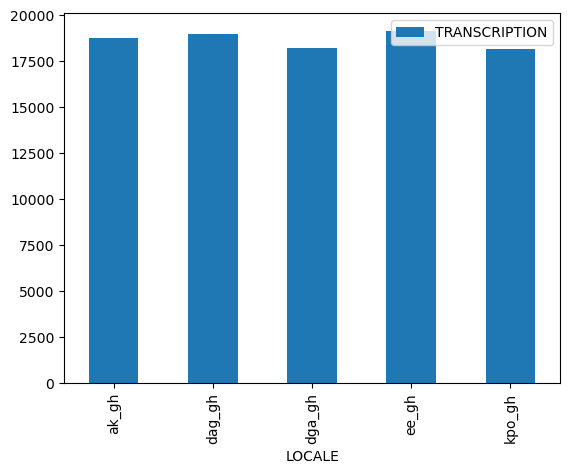

In [121]:
#Display the plot of Transcription against locale in a bar chart format
grouped_df = final_df.groupby('LOCALE').count()[['TRANSCRIPTION']]

grouped_df.plot(kind='bar')
plt.show()


In [122]:
#Displays number of entries corresponding to each locale on a bar chart
def data_distribution(data):
    plt.figure(figsize=(16,3))
    data.LOCALE.value_counts().plot(kind='bar', title="Data Category distribution")
    plt.show()


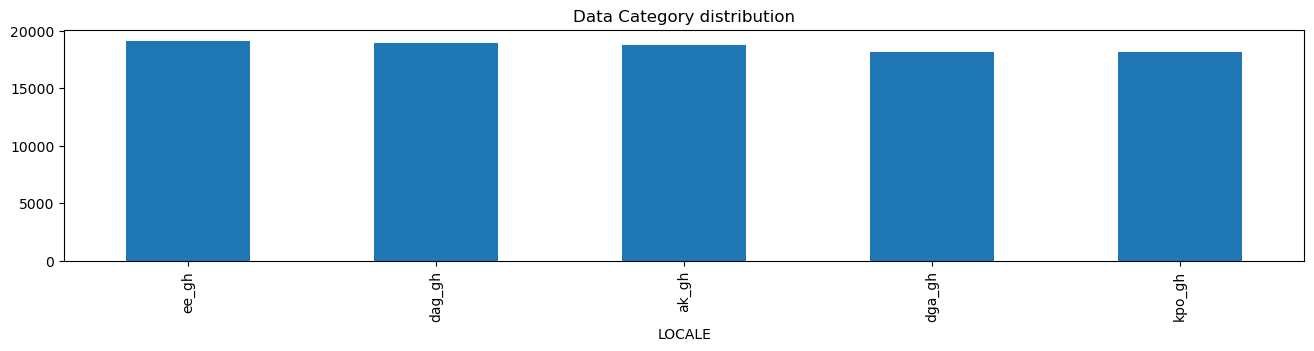

In [123]:
#calls the function above
data_distribution(final_df)

In [124]:
# obtain the first occurence of a given locale from a provided dataframe, this information is used later for data visualization purposes
def get_first_locale_occurence(df, locale):
    return df[df['LOCALE'] == locale].head(1)

In [125]:
# displays audio file into its spectrogram format, which is the format that all audio files will be converted to be able to use it for training
def spectrogram(file_path, locale):
    y, sr = lib.load(file_path)
    plt.figure(figsize=(16,3))
    plt.title(locale + 'Log-Frequency Power Spectrogram')
    data = lib.amplitude_to_db(np.abs(lib.stft(y)), ref=np.max)
    lib.display.specshow(data, y_axis='log', x_axis='time')
    plt.colorbar();

In [126]:
# Displays audio file in its corresponding wave format
def waveform(file_path, label):
    y, sr = lib.load(file_path)
    plt.figure(figsize=(16, 3))
    plt.title(label + ' Sound Wave')
    lib.display.waveshow(y, color="blue")
    # librosa.display.waveshow(y, sr=sr)

In [127]:
# plays raw audio, one which can be heard
def play_raw_audio_File(file_path):
    return ipd.Audio(file_path) #to hear sound play in Notebooks not interactive shell like IPython

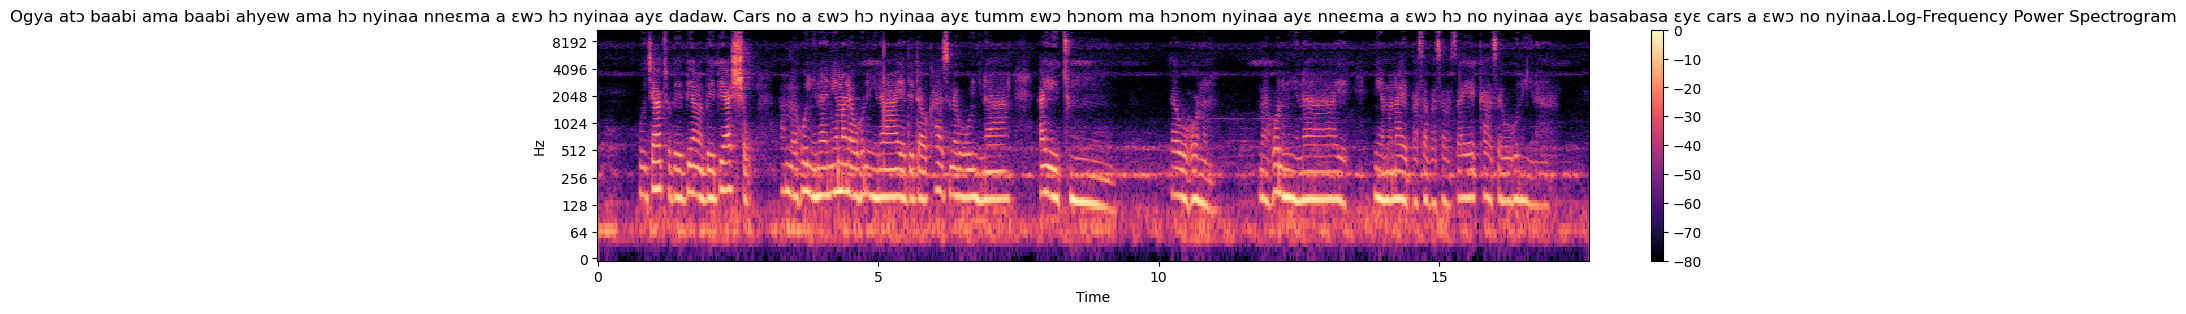

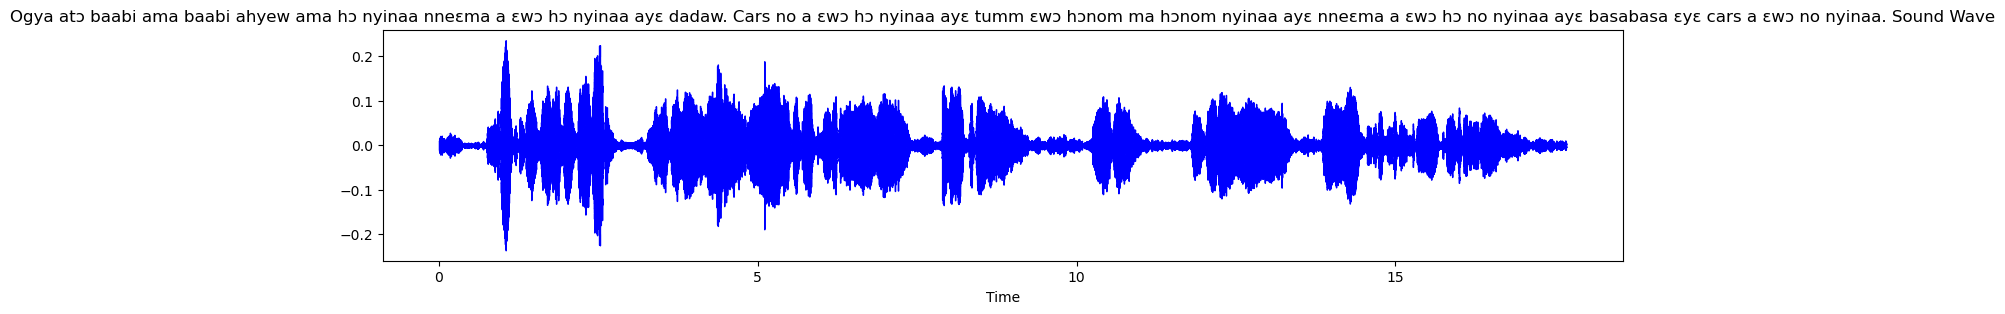

In [233]:
#Display the spectrogram, waveform and raw audio play of the first akan language audio file in the final dataframe
akan1_pd = get_first_locale_occurence(final_df, 'ak_gh')
audio_path_akan = akan1_pd.iloc[0].AUDIO_PATH
transcription_akan = akan1_pd.iloc[0].TRANSCRIPTION
audio_unix_akan = get_audio_path_unix(audio_path_akan)
# print(audio_unix_akan)
#
spectrogram(audio_unix_akan, transcription_akan)


#
waveform(audio_unix_akan, transcription_akan)


#
play_raw_audio_File(audio_unix_akan)

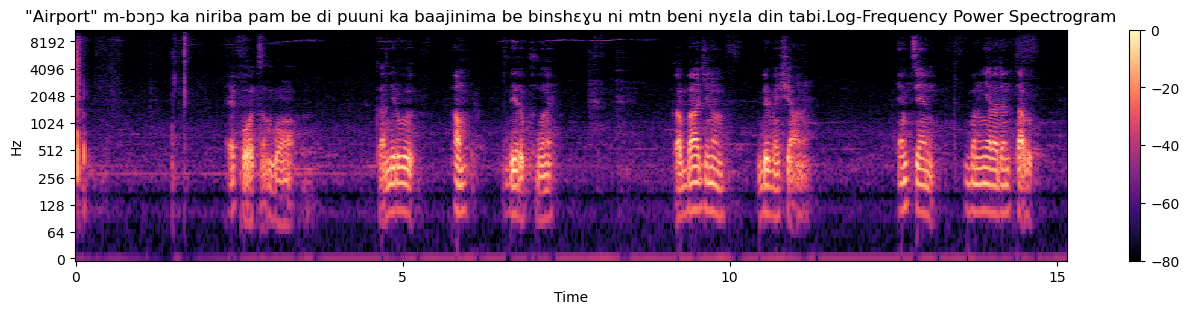

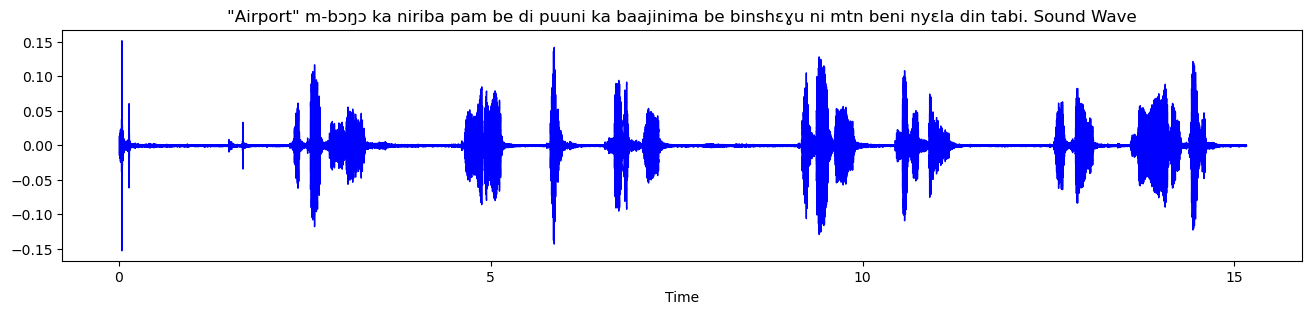

In [229]:
#Display the spectrogram, waveform and raw audio play of the first dagbani language audio file in the final dataframe
dagbani1_pd = get_first_locale_occurence(final_df, 'dga_gh')
audio_path_dagbani = dagbani1_pd.iloc[0].AUDIO_PATH
transcription_dagbani = dagbani1_pd.iloc[0].TRANSCRIPTION
audio_unix_dagbani = get_audio_path_unix(audio_path_dagbani)
# print(audio_unix_dagbani)

#
spectrogram(audio_unix_dagbani, transcription_dagbani)

#
waveform(audio_unix_dagbani, transcription_dagbani)

#Dagbani
play_raw_audio_File(audio_unix_dagbani)

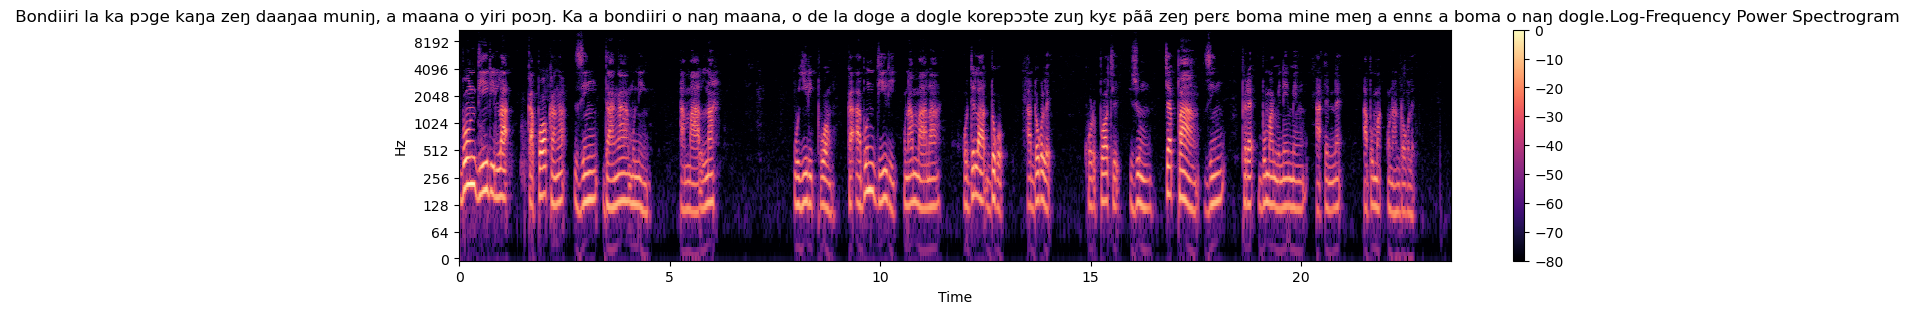

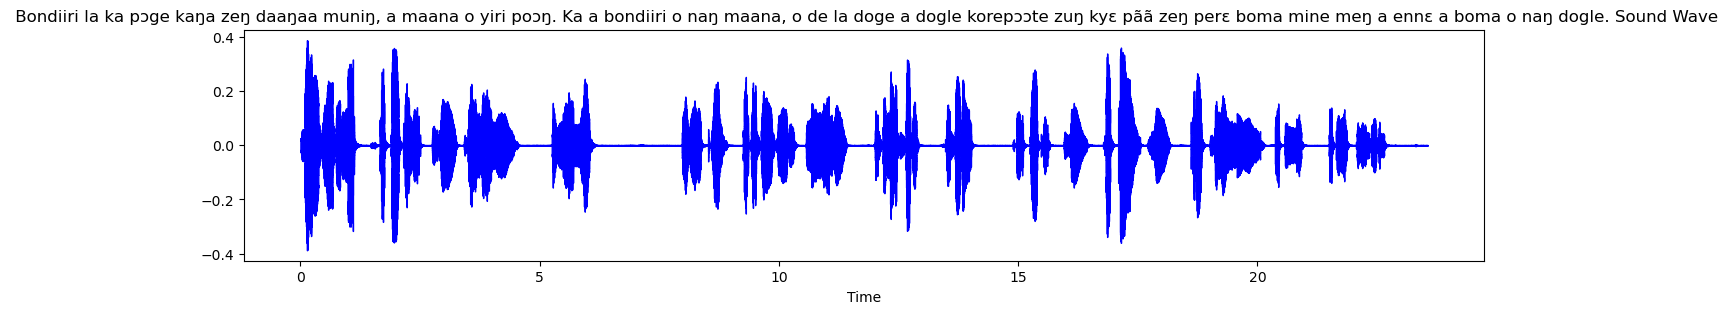

In [230]:
#Display the spectrogram, waveform and raw audio play of the first dagaare language audio file in the final dataframe
dagaare1_pd = get_first_locale_occurence(final_df, 'dag_gh')
audio_path_dagaree = dagaare1_pd.iloc[0].AUDIO_PATH
transcription_dagaare = dagaare1_pd.iloc[0].TRANSCRIPTION
audio_unix_dagaare = get_audio_path_unix(audio_path_dagaree)
# print(audio_unix_dagaare)
#
spectrogram(audio_unix_dagaare, transcription_dagaare)

#Dagaare
waveform(audio_unix_dagaare, transcription_dagaare)

#Dagaare
play_raw_audio_File(audio_unix_dagaare)

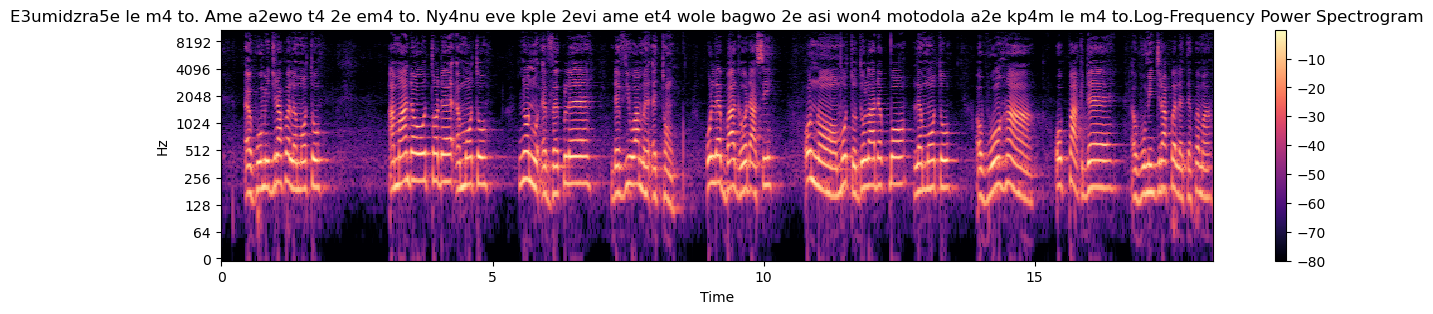

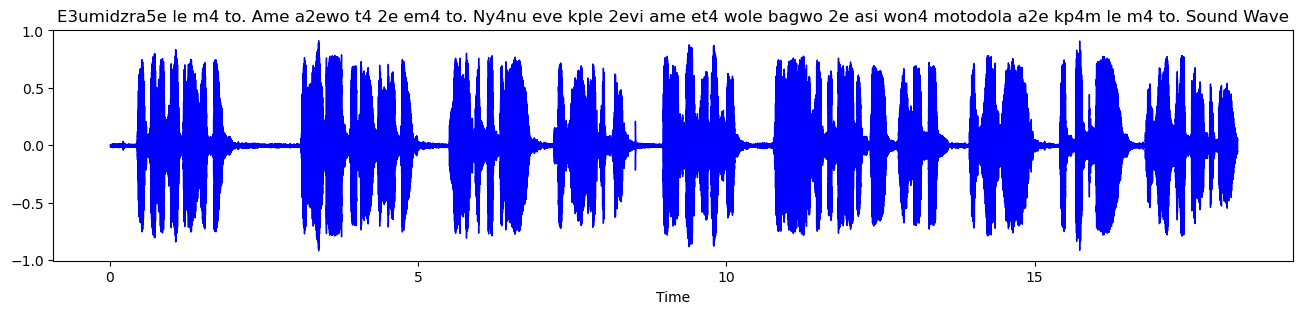

In [231]:
# Display the spectrogram, waveform and raw audio play of the first Ewe language audio file in the final dataframe
ewe1_pd = get_first_locale_occurence(final_df, 'ee_gh')
audio_path_ewe = ewe1_pd.iloc[0].AUDIO_PATH
transcription_ewe = ewe1_pd.iloc[0].TRANSCRIPTION
audio_unix_ewe = get_audio_path_unix(audio_path_ewe)
# print(audio_unix_ewe)
#
spectrogram(audio_unix_ewe, transcription_ewe)

#Ewe
waveform(audio_unix_ewe, transcription_ewe)

#Ewe
play_raw_audio_File(audio_unix_ewe)

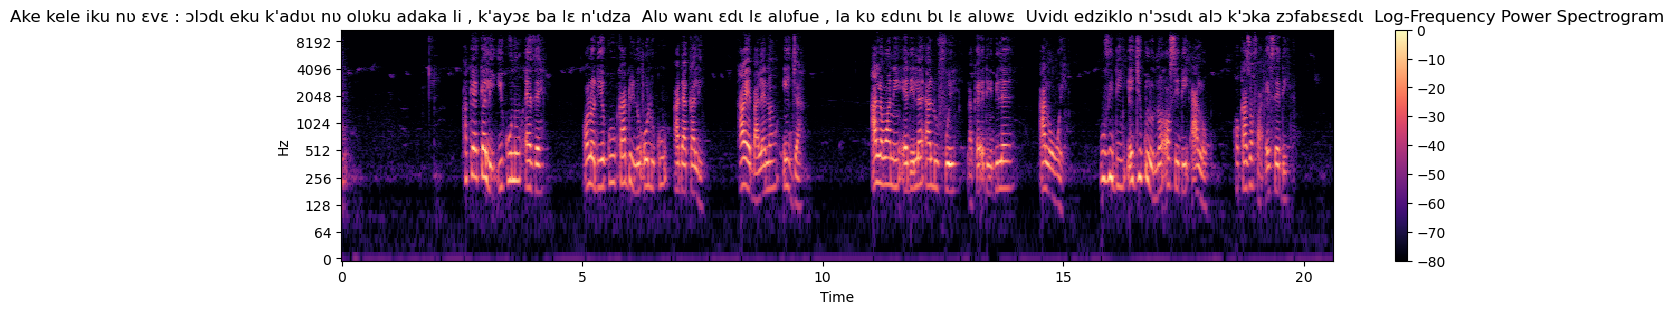

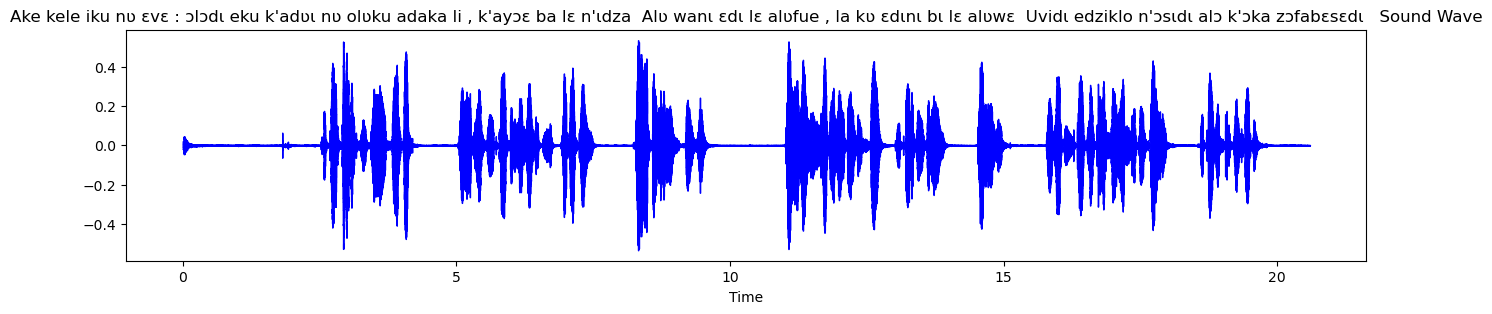

In [232]:
# Display the spectrogram, waveform and raw audio play of the first ikposo language audio file in the final dataframe
ikposo1_pd = get_first_locale_occurence(final_df, 'kpo_gh')
audio_path_ikposo = ikposo1_pd.iloc[0].AUDIO_PATH
transcription_ikposo = ikposo1_pd.iloc[0].TRANSCRIPTION
audio_unix_ikposo = get_audio_path_unix(audio_path_ikposo)
# print(audio_unix_ikposo)
#
spectrogram(audio_unix_ikposo, transcription_ikposo)

#Ikposo
waveform(audio_unix_ikposo, transcription_ikposo)

#Ikposo
play_raw_audio_File(audio_unix_ikposo)

In [134]:
# Read specific column in Excel file 
# key value below represent unique columns in each of the languages with respect to IMAGE_SRC_URL column
# 0: 1147: Ikposo
# 1: 945: Ewe
# 2: 633: Dagbani
# 3: 1001: Dagaare
# 4: 1022: Akan
# Note: takes about 2mins to complete
df = pd.read_excel(fileList[2])

# Extract unique values in IMAGE_SRC_URL column to analyze the count of different image described in the audio
unique_values = df['IMAGE_SRC_URL'].unique()

In [135]:
#Print count of unique values
print(len(unique_values))

633


In [136]:
#Prints first unique IMAGE_SRC_URL in the unique_values list
unique_values[1]

'https://images.pexels.com/photos/279648/pexels-photo-279648.jpeg?auto=compress&cs=tinysrgb&dpr=1&w=500'

In [137]:
# Sample data
labels = np.array(final_df['IMAGE_SRC_URL'].tolist())

# Get unique labels and their counts
unique_labels, label_counts = np.unique(labels, return_counts=True)

In [138]:
# signifies the number of occurence of the audio data dedicated to the image, e.g. for unique label index 0 its number of occurence corresponds to
# array index 0 on label_counts
len(label_counts)

2028

In [139]:
unique_labels

array(['https://10mosttoday.com/wp-content/uploads/2018/06/Animal-Powered-Transport.jpg',
       'https://10mosttodaycom/wp-content/uploads/2018/06/Animal-Powered-Transportjpg',
       'https://149516130.v2.pressablecdn.com/wp-content/uploads/2019/05/miners.jpg',
       ...,
       'https://wwwznbccozm/news/wp-content/uploads/2022/11/aunty-to-debora-720x540jpeg',
       'https://zamzam.com/blog/wp-content/uploads/2021/10/e-visa-for-hajj-umrah.jpg',
       'https://zamzamcom/blog/wp-content/uploads/2021/10/e-visa-for-hajj-umrahjpg'],
      dtype='<U196')

In [140]:
# Get number of occurence of any or a specified unique image src url
count_of_value = (final_df['IMAGE_SRC_URL'] == unique_labels[8]).sum()
count_of_value

82

In [141]:
#The maximum count recorded of an IMAGE_SRC_URL being transcribed or described
np.max(label_counts)

575

In [144]:
#The minimum count recorded of an IMAGE_SRC_URL being transcribed or described
np.min(label_counts)

1

In [145]:
# Function to sample based on critial/integral factor, in this the factor or column happens to be IMAGE_SRC_URL
# IT was chosen as a factor for sampling because it is the what the audio is all about, that is, a variety of people describing 
# a provided image, in any of the five language, could be all for some of the images. Transcription seems to be a tempting factor to
# use for sampling intially but after several thoughts and test leading to very vague and unsamplable results which are often large,
# the IMAGE_SRC_URL seems to be the best factor. as it serves as a key part of both the feature[audio] and label[Transcription], providing 
# great insight into both factors.
def sample_by_label(df, label_column, sample_size):
    # Group DataFrame by label column
    grouped = df.groupby(label_column)
    
    # Determine the minimum count of samples among all label groups
    min_count = grouped.size().min()
    print(min_count)
    
    # Sample uniformly from each label group
    sampled_dfs = []
    for label, group_df in tqdm(grouped):
        sampled_df = group_df.sample(n=min_count, random_state=42)  # Adjust random_state as needed for reproducibility
        sampled_dfs.append(sampled_df)
    
    # Combine sampled subsets to obtain the final balanced dataset
    sampled_df = pd.concat(sampled_dfs)
    
    
    return sampled_df

# Sample based on label
balanced_sampled_df = sample_by_label(final_df, 'IMAGE_SRC_URL', sample_size=10)


1


100%|█████████████████████████████████████| 2028/2028 [00:01<00:00, 1022.60it/s]


In [146]:
# View of information on final dataframe to compare with the cell below which provides information 
# on the balanaced sampled data
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93166 entries, 700 to 688
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   IMAGE_PATH     93166 non-null  object
 1   IMAGE_SRC_URL  93166 non-null  object
 2   AUDIO_PATH     93166 non-null  object
 3   TRANSCRIPTION  93166 non-null  object
 4   LOCALE         93166 non-null  object
 5   FULL_FILENAME  93166 non-null  object
dtypes: object(6)
memory usage: 5.0+ MB


In [147]:
# View on balanced sampled.
balanced_sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2028 entries, 17777 to 1376
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   IMAGE_PATH     2028 non-null   object
 1   IMAGE_SRC_URL  2028 non-null   object
 2   AUDIO_PATH     2028 non-null   object
 3   TRANSCRIPTION  2028 non-null   object
 4   LOCALE         2028 non-null   object
 5   FULL_FILENAME  2028 non-null   object
dtypes: object(6)
memory usage: 110.9+ KB


In [148]:
# View on sampled dataframe diversity across the five locales/langugeas
balanced_sampled_df.LOCALE.value_counts()

LOCALE
kpo_gh    1018
ak_gh      330
ee_gh      268
dag_gh     229
dga_gh     183
Name: count, dtype: int64

In [57]:
#Creates a working directory for data augmentation purposes. Data augmentation was consideered because of the imbalance in the 
# existing in the dataframe
os.mkdir(dir+'working/')
os.mkdir(dir+'working/Data2') # creates the Data2 directory where all unique files sampled and stored as balanced_sampled_df is saved

In [58]:
# Counts of unique Transcriptions in the balanced sampled dataframe to give insight on the count of unique transcription
# is staring off with
unique_values_B = balanced_sampled_df['TRANSCRIPTION'].unique()
len(unique_values_B)

2028

In [179]:
#Creates a new dataframe and initialize a copy of the balanced_sample_dataframe to it. Copy was used in order to still have
# an untampered version of the starting state of the balanced data. In the case were copy isn't used, whatever changes is made in
# either of the dataframes[i.e. balanced_sampled_df and updated_balanced_df] affects the other.
updated_balanced_df = balanced_sampled_df.copy()

In [180]:
# Gets all unique locale values and saves as a list
locales = updated_balanced_df['LOCALE'].unique().tolist()
type(locales)
locales #returns a list of all unique locales

['ee_gh', 'kpo_gh', 'dag_gh', 'dga_gh', 'ak_gh']

The aim of the cell below is to reduce the counts of entries for each local to a 20 or around 20, could be 21. 
Reducing sample size further makes it easier to deal with problem in manageable chunks possible for the limited 
resources the personal computer used could bear, e.g. processor, storage, etc. It also allows for eventual consistent 
growth in size while enhancing the several avenues to experiment on values or factors in any of the steps that unfolds in the
cells below, e.g. trainng, testing, evaluation, further pre-processing

In [182]:
# Define the maximum count for each locale
max_count_per_locale = 20

# Loop through the DataFrame and reduce the count of each locale to 20
for locale in tqdm(locales): 
    # Get the indices of rows with the current locale
    locale_indices = updated_balanced_df.index[updated_balanced_df['LOCALE'] == locale].tolist()
    
    # Shuffle the indices to randomly sample rows
    np.random.shuffle(locale_indices)
    
    # Keep only the first max_count_per_locale indices
    indices_to_keep = locale_indices[:max_count_per_locale]
    
    # Drop rows not in indices_to_keep
    updated_balanced_df = updated_balanced_df.drop(index=set(locale_indices) - set(indices_to_keep))

# Reset index after dropping rows
updated_balanced_df = updated_balanced_df.reset_index(drop=True)

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 61.67it/s]


In [183]:
# Provides information on the further shrinked/reduced sampled dataframe size
updated_balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   IMAGE_PATH     99 non-null     object
 1   IMAGE_SRC_URL  99 non-null     object
 2   AUDIO_PATH     99 non-null     object
 3   TRANSCRIPTION  99 non-null     object
 4   LOCALE         99 non-null     object
 5   FULL_FILENAME  99 non-null     object
dtypes: object(6)
memory usage: 4.8+ KB


In [184]:
# Display the updated sampled DataFrame with respects to its locale diversity
updated_balanced_df.LOCALE.value_counts()

LOCALE
ak_gh     21
dag_gh    20
kpo_gh    20
ee_gh     19
dga_gh    19
Name: count, dtype: int64

In [69]:
#copies files from folder into Data2, these files comes from at least one of the five locales 'selected transcribed audios' folder
# with information on path provided in the dataframe column AUDIO_PATH
def fill_folder1_toData2(): #copy files using the file path in the dataframe to the Data2 directory
    destination = dir+'working/Data2/'

    # Iterate over the files and copy them to the destination directory
    for audio_file in tqdm(updated_balanced_df.AUDIO_PATH): #balanced_sampled_df
        source_file = get_audio_path_unix(audio_file)
        destination_file = os.path.join(destination, os.path.basename(source_file))
        shutil.copy2(source_file, destination_file)

fill_folder1_toData2() #call function to begin the copy

100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 444.14it/s]


In [73]:
# saves balanced_sampled_df in case kernel develops an issue or hangs for quick retriveal in order to save time on 
# numerous unnecessary rerun of cells and functions all over again any time an issue is encountered
balanced_sampled_df.to_excel(dir+'working/'+'balanced_sampled_df.xlsx', index=False)

In [74]:
# get the files residing inside a given directory.
def get_fileNames(path): 
       onlyfiles = next(os.walk(path))[2] 
       return onlyfiles

In [75]:
#returns counts of files executed by get_fileNames
len(get_fileNames(dir+'working/Data2'))

99

In [76]:
# Pitch shifting involves changing the frequency content of an audio signal while preserving its duration. This can be achieved using 
# digital signal processing techniques such as time-stretching. in the case of some audio files this form of augmentation 
# rendered it currupted
def changing_pitch(step, src_path, dst_path):
    files = get_fileNames(src_path)
    # print(len(files))
    if not os.path.exists(dst_path):
      os.makedirs(dst_path)
    for file in tqdm(files):
      filename = os.path.basename(file).replace(directory, "")
      y, sr = lib.load(src_path+'/'+file)
      updated_y = lib.effects.pitch_shift(y, sr=sr, n_steps=step)
      soundfile.write(dst_path + '/' + filename.split('.mp3')[0] + '_' + str(step) + '.mp3', updated_y, sr)

In [77]:
# Audio file augmented through audio signal speed change or through time strectching, it is going to be the form of 
# augmnetation going to be administered on the files which upon pitch change became currupted
def changing_speed(speed_rate, src_path, dst_path):
    files = get_fileNames(src_path)
    if not os.path.exists(dst_path):
      os.makedirs(dst_path)
    for file in tqdm(files):
      filename = os.path.basename(file).replace(directory, "")
      y, sr = lib.load(src_path+"/"+file)
      updated_y = lib.effects.time_stretch(y, rate=speed_rate)
      soundfile.write(dst_path + '/' + filename.split('.mp3')[0] + '_' + str(speed_rate) + ".mp3", updated_y, sr)


In [78]:
# provide paramter or step for changing the pitch and speed of the audio signal.
def sound_augmentation(src_path, dst_path):
    steps = [2, -2, 2.5, -2.5] #Steps changing value range list
    for step in steps:
        changing_pitch(step, src_path, dst_path)

    speed_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8] #Speed rate changing value range list
    for speed_rate in speed_rates:
        changing_speed(speed_rate, src_path, dst_path)

    files = get_fileNames(src_path)
    for f in files:
      shutil.copy(src_path+'/'+f, dst_path) # after changing pitch of each file, it copy all files who pitch has been changed to provided destination folder

In [79]:
# creates audio data through pitch shifting
def create_new_augmented_data_files():
    # Checking and creating new directory for saving newly generated audio files using data augmentation
    if os.path.exists(dir+'working/OUT'):
      if len(get_fileNames(dir+'working/OUT')) == 6750:
          print('Sound Augmentation Already Done and Saved')
      else:
          shutil.rmtree(dir+'working/OUT')
          sound_augmentation(dir+'working/Data2', dir+'working/OUT')
    else:
        sound_augmentation(dir+'working/Data2', dir+'working/OUT')


In [80]:
# calls creates create_new_augmented data files function to commence with data augmentation.
create_new_augmented_data_files()

100%|███████████████████████████████████████████| 99/99 [01:00<00:00,  1.63it/s]


In [81]:
#handles case where oringal file needs to be retrieved after augmented in order to be able to reasign other details of it such
# transcription, locale, image_src_url details etc. This function is very intergral yo the create_dataframe function in one of the cells below
def get_aug_file(file):
    
    if file.__contains__('_2.mp3'): 
        return file.split('_2.mp3')[0]+'.mp3' #other returns None type not ""
        
    elif (file.__contains__('_-2.mp3')):
           return file.split('_-2.mp3')[0]+'.mp3' 
        
    elif (file.__contains__('_2.5.mp3')):
           return file.split('_2.5.mp3')[0]+'.mp3' 
        
    elif (file.__contains__('_-2.5.mp3')):
           return file.split('_-2.5.mp3')[0]+'.mp3'
        
    elif (file.__contains__('_0.1.mp3')):
           return file.split('_0.1.mp3')[0]+'.mp3'
        
    elif (file.__contains__('_0.2.mp3')):
           return file.split('_0.2.mp3')[0]+'.mp3'

    elif (file.__contains__('_0.3.mp3')):
           return file.split('_0.3.mp3')[0]+'.mp3'
        
    elif (file.__contains__('_0.4.mp3')):
           return file.split('_0.4.mp3')[0]+'.mp3'

    elif (file.__contains__('_0.5.mp3')):
           return file.split('_0.5.mp3')[0]+'.mp3'
        
    elif (file.__contains__('_0.6.mp3')):
           return file.split('_0.6.mp3')[0]+'.mp3'

    elif (file.__contains__('_0.7.mp3')):
           return file.split('_0.7.mp3')[0]+'.mp3'

    elif (file.__contains__('_0.8.mp3')):
           return file.split('_0.8.mp3')[0]+'.mp3'
        
    else:
        return file


In [82]:
# Gets transcription with audio file provided from a particular dataframe
def get_transcription_with_audio(df, audio_file):   
   for row in df.FULL_FILENAME:
       if get_aug_file(row) == get_aug_file(audio_file):
          transcription = df[df['FULL_FILENAME'] == row].TRANSCRIPTION.iloc[0]
          return transcription
        

In [83]:
# Gets locale with audio file provided from a particular dataframe
def get_locale_with_audio(df, audio_file):   
   for row in df.FULL_FILENAME:
       if get_aug_file(row) == get_aug_file(audio_file):
          locale = df[df['FULL_FILENAME'] == row].LOCALE.iloc[0]
          return locale

In [84]:
# Gets image src url with audio file provided from a particular dataframe 
def get_image_src_url_with_audio(df, audio_file):   
   for row in df.FULL_FILENAME:
       if get_aug_file(row) == get_aug_file(audio_file):
          image_src_url = df[df['FULL_FILENAME'] == row].IMAGE_SRC_URL.iloc[0]
          return image_src_url

In [85]:
#create a dataframe for augmented files with the help of sample files used for augmentation
def create_dataframe(dataframe_name, folder_path):
    new_df = {'FULL_FILENAME': [], 'TRANSCRIPTION': [], 'LOCALE': [], 'IMAGE_SRC_URL':[]}

    #
    fileNames = get_fileNames(folder_path)
    for file in tqdm(fileNames):
    
        # adds row's FULL_FILENAME entry
        new_df['FULL_FILENAME'].append(file)
        
        # adds row's Transcription entry
        transcription = get_transcription_with_audio(dataframe_name, file)
        new_df['TRANSCRIPTION'].append(transcription)
        
        # adds row's Locale entry
        locale = get_locale_with_audio(dataframe_name, file)
        new_df['LOCALE'].append(locale)
        
        # adds row's IMAGE_SRC_URL entry
        image_src_url = get_image_src_url_with_audio(dataframe_name, file)
        new_df['IMAGE_SRC_URL'].append(image_src_url)
    
    #declares and initializes new dataframe to contain the the details of the data contained in the OUT folder 
    #post augmentation(as a result of augmentation)    
    augmented_df = pd.DataFrame(new_df)
    return augmented_df

In [86]:
# creates dataframe containg augmented files and initial audio files in the Data2 folder
aug_df = create_dataframe(updated_balanced_df, dir+'working/OUT')

100%|██████████████████████████████████████| 1287/1287 [00:02<00:00, 475.94it/s]


In [87]:
# provides information on the new created dataframe
aug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1287 entries, 0 to 1286
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   FULL_FILENAME  1287 non-null   object
 1   TRANSCRIPTION  1287 non-null   object
 2   LOCALE         1287 non-null   object
 3   IMAGE_SRC_URL  1287 non-null   object
dtypes: object(4)
memory usage: 40.3+ KB


In [88]:
# check for currupted file and remove from both dataframe and folder
def remove_currupted_audio(folder_path, data_frame):
    fileList = get_fileNames(folder_path)
    cur = 0
    not_cur = 0
    
    for file in tqdm(fileList):
        try:
            y, sr = lib.load(folder_path+file) #removed duration value of duration=3s
            # print(file)
            not_cur = not_cur+1
            
        except EOFError as e:
           #remove from folder
           os.remove(folder_path+file)

           #get row index
           index = data_frame[(data_frame.FULL_FILENAME == file)].index
           #remove from dataframe
           data_frame = data_frame.drop(index)
            
           cur = cur+1
           # print(e.with_traceback)
    return data_frame

    print(cur)
    print(not_cur)
        

In [91]:
# Noticed a couples of files upon augmentation ended up currupted hence created a function to detect them and get rid of them
df_aug_updated = remove_currupted_audio(dir+'working/OUT/', aug_df)

100%|███████████████████████████████████████| 1287/1287 [00:54<00:00, 23.69it/s]


In [92]:
# Updated Dataframe state after removing all currupted files
df_aug_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1287 entries, 0 to 1286
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   FULL_FILENAME  1287 non-null   object
 1   TRANSCRIPTION  1287 non-null   object
 2   LOCALE         1287 non-null   object
 3   IMAGE_SRC_URL  1287 non-null   object
dtypes: object(4)
memory usage: 40.3+ KB


In the case of absence of currupted audio data, both df_aug_updated and aug_df are going to end 
up with the same value

In [93]:
# Initial dataframe state prior to augmentation
aug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1287 entries, 0 to 1286
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   FULL_FILENAME  1287 non-null   object
 1   TRANSCRIPTION  1287 non-null   object
 2   LOCALE         1287 non-null   object
 3   IMAGE_SRC_URL  1287 non-null   object
dtypes: object(4)
memory usage: 40.3+ KB


In [94]:
#sort index incase of removal of currupted files
df_aug_updated.sort_index(inplace=True)

In [95]:
#compare augmented dataframe with its updated version to get rid of currupted files, this is in order to obtain the files
#that were lost in the process as they led to an un-even distribution in the class distribution in split of dataset for 
# training and testing: Error snapshot during  StratifiedShuffleSplit: 'The least populated class in y has only 1 
# member, which is too few. The minimum number of groups for any class cannot be less than 2.'
df_diff = pd.merge(aug_df, df_aug_updated, how='outer', suffixes=('','_y'), indicator=True)
rows_in_df1_not_in_df2 = df_diff[df_diff['_merge']=='left_only'][aug_df.columns]

#get length of deleted currupted files
len(rows_in_df1_not_in_df2)

currupted_files_df = rows_in_df1_not_in_df2
currupted_files_df

Empty DataFrame
Columns: [FULL_FILENAME, TRANSCRIPTION, LOCALE, IMAGE_SRC_URL]
Index: []

In [96]:
currupted_files = currupted_files_df['FULL_FILENAME'].tolist() # Get all the list of currupted files
currupted_files #print list

[]

In [ ]:
# Only necessary when there are currupted files
os.mkdir(dir+'working/TEMP/') #creates a TEMP folder where the initial version of audio files corresponding to the currupted augmented file are stored for another appropriate form of augmentation to make dataset distribution tally or have at least more than two occuring version of a transcription
source_folder = dir+"working/Data2/" 
destination_folder = dir+"working/TEMP/"

# fetch all files from source folder corresponding to deleted currupted files into the TEMP directory in the working directory
for file in tqdm(currupted_files):
    # 
    file_original_name = get_aug_file(file)
    
    if os.path.exists(source_folder+file_original_name):
        #
        source = source_folder + file_original_name
        destination = destination_folder

        # copy only files
        if os.path.isfile(source):
            shutil.copy(source, destination)
            print('copied', file)

    else:
        print('File doesnt exist')

In [ ]:
# administers sound augmentation
# Only necessary when there are currupted files
def sound_aug_without_copy(src_path, dst_path):
    speed_rates = [0.21, 0.22, 0.23, 0.23, 0.24, 0.25] #
    for speed_rate in speed_rates:
        changing_speed(speed_rate, src_path, dst_path)

In [ ]:
# Only necessary when there are currupted files
os.mkdir(dir+'working/OUT_TEMP') #creates a folder OUT_TEMP where all newly augmented files in the TEMP folder are kept
for file in currupted_files:
    #original file prior to augmentation, since increasing pitch by 2 
    #currupted audio,this time pitch reduction is going to be administed on the files
    #pitch change to this files keep failing so an alternate augmentation procedure was administer, i.e. speed change
    original_file = get_aug_file(file)

    sound_aug_without_copy(dir+'working/TEMP', dir+'working/OUT_TEMP')
    

In [ ]:
# calls check_currupted_audio file function
# Only necessary when there are currupted files
check_currupted_audio(dir+'working/OUT_TEMP/')

In [ ]:
#create a new dataframe for re-augmented currupted files
# Only necessary when there are currupted files
re_aug_df = create_dataframe(currupted_files_df, dir+'working/OUT_TEMP')

In [ ]:
# Only necessary when there are currupted files
re_aug_df.info()

In [ ]:
#add re-augmented dataframe to the updated dataframe which was rid of the currupted files(df_aug_updated)
# Only necessary when there are currupted files
aug_frames = [df_aug_updated, re_aug_df]
final_aug_df = pd.concat(aug_frames, ignore_index=True)


In [ ]:
# Display re-augmnted dataframe information to verify or process taken to restore it to its initial size of 13,500
# Only necessary when there are currupted files
final_aug_df.info()
display(final_aug_df)

In [ ]:
#copy re-augmented currupted files into OUT folder
# Only necessary when there are currupted files

source_folder = dir+"working/OUT_TEMP/"
destination_folder = dir+"working/OUT/"

out_temp_files = get_fileNames(source_folder)

# fetch all files
for file in tqdm(out_temp_files):
    
    if os.path.exists(source_folder+file):
        #
        source = source_folder + file
        destination = destination_folder

        # copy only files
        if os.path.isfile(source):
            shutil.copy(source, destination)
            print('copied', file)

    else:
        print('File doesnt exist')

In [ ]:
#Splits data into training and testing
def split_for_training_testing(final_data):
    # Splitting the Data into Training Data and Testing Data in the proportion of 80:20 (Train:Test)
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in split.split(final_data, final_data.label):
        train_data = final_data.loc[train_idx]
        test_data = final_data.loc[test_idx]
        return [train_data, test_data]

In [101]:
# Declare and initializes both the train and test data
train_data, test_data = split_for_training_testing(df_aug_updated) #final_aug_df

In [102]:
# Provides informtion on train_data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 900 entries, 985 to 1137
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   FULL_FILENAME  900 non-null    object
 1   TRANSCRIPTION  900 non-null    object
 2   LOCALE         900 non-null    object
 3   IMAGE_SRC_URL  900 non-null    object
dtypes: object(4)
memory usage: 35.2+ KB


In [4]:
# Saves train data for future use or quick retrival incase kernel hangs or is currupted with unintended values
train_data.to_excel(dir+'working/'+'train_data.xlsx', index=False)

In [105]:
# Saves test data for future use or quick retrival incase kernel hangs or is currupted with unintended values
test_data.to_excel(dir+'working/'+'test_data.xlsx', index=False)

In [96]:
# Provides informtion on test_data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   FULL_FILENAME  387 non-null    object
 1   TRANSCRIPTION  387 non-null    object
 2   LOCALE         387 non-null    object
 3   IMAGE_SRC_URL  387 non-null    object
dtypes: object(4)
memory usage: 12.2+ KB


The aim of the function below is to normalize Transcription, i.e. label to a format that is acceptable or compartible to
the chosen or selected Deep Learning model to be used, which in this case the Convoluntional Neural network(CNN), with regards to CNN,
labels are normally normalized to numerical numpy array of two dimension, with the first corresponding to sample size and the second
more insights into the nature or the factor normalized, for this case it was the sequnce of characters leveraging tokenizers, which happens
to handle strings in it character format

In [185]:
#declare and initialize tokenizer
tokenizer = Tokenizer(char_level=True)  # Character-level tokenization

def prep_label(y_label):
    # Example long transcriptions
    transcriptions = y_label
    
    # Tokenization
    tokenizer.fit_on_texts(transcriptions)
    sequences = tokenizer.texts_to_sequences(transcriptions)
    
    # Calculate sequence lengths
    sequence_lengths = [len(seq) for seq in sequences]
    
    # Visualize sequence length distribution
    # plt.hist(sequence_lengths, bins=30)
    # plt.xlabel('Sequence Length')
    # plt.ylabel('Frequency')
    # plt.title('Distribution of Sequence Lengths')
    # plt.show()
    
    # Determine maximum padding sequence length
    max_length = max(sequence_lengths)
    print("Maximum Sequence Length:", max_length)
    
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    # Convert to numpy array
    prep_y_label = padded_sequences

    # Print the shape of the data
    print("Shape of Y_label:", prep_y_label.shape)
    
    return prep_y_label

In [186]:
# declares and initializes the y_train value by passing it through the prep_label function
y_train = prep_label(train_data['TRANSCRIPTION'])

Maximum Sequence Length: 351
Shape of Y_label: (900, 351)


In [106]:
# declares and initializes the y_test value by passing it through the prep_label function
y_test = prep_label(test_data['TRANSCRIPTION'])

Maximum Sequence Length: 351
Shape of Y_label: (387, 351)


In [120]:
# Gets number of sequence existing in the Transcription upon normalization
y_train.shape[1]

351

In [122]:
# saves y_train value for future use
np.save(dir+'working/y_train.npy', y_train)

In [123]:
# saves y_test value for future use
np.save(dir+'working/y_test.npy', y_test)

Th cell below gives clear insights into all the unique characters in which the model will be trying to predict while listenting to each 
of their corresponding sounds, for this particular sample size there were 91 unique characters. Thanks to Stratified splits this values remains the same across both test and train data labels

In [125]:
# Assuming you have a list of transcriptions as NumPy arrays
transcriptions = train_data['TRANSCRIPTION'] # List of NumPy arrays containing transcriptions, because of Stratified split both test and train data has same number of unique chars

# Convert each NumPy array to a string
transcriptions_str = ["".join(map(str, arr)) for arr in transcriptions]

# Concatenate all transcriptions into a single string
all_text = ''.join(transcriptions_str)

# Get unique characters in the concatenated text
unique_characters = set(all_text)

# Compute the number of characters in the transcription vocabulary
num_chars = len(unique_characters)

print("Number of characters in the transcription vocabulary:", unique_characters)
print("Number of characters in the transcription vocabulary:", num_chars)

Number of characters in the transcription vocabulary: {'1', 'l', 'Z', '5', 'ʒ', 'ƙ', 'G', 'B', '-', '3', 'M', 'w', 'ò', 'ɣ', 'Ɩ', 'ԑ', 'b', 'u', 'ɔ', 'N', 'm', 'ŋ', '`', 'P', 'ɛ', 'ɡ', 'ʋ', 'h', '~', 'ɖ', 'ũ', '6', 'ɩ', 'é', 'D', 'A', 'ƶ', 'i', 'U', 'ʊ', 'v', '̃', 'Ɔ', 'ͻ', 'n', 'f', 'g', "'", '4', 'Ɛ', 'T', 'r', ' ', '…', 'W', 'Y', 'H', 'L', 'S', 'z', 'a', 'X', 'ã', '7', 'í', 'k', '\xa0', '=', '2', '.', 'p', 'K', 'c', 'ƴ', '8', ';', 'ƒ', 'F', 'O', 'd', 'o', 'e', 'ǝ', 't', 'x', ',', 'E', 's', '@', 'y', 'j'}
Number of characters in the transcription vocabulary: 91


In [5]:
# Specifies the path to excel file
data_excel_file = dir+'working/test_data.xlsx'

# loads the Excel file into a pandas DataFrame
test_data = pd.read_excel(data_excel_file)

# Displays the first few rows of the DataFrame
test_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   FULL_FILENAME  387 non-null    object
 1   TRANSCRIPTION  387 non-null    object
 2   LOCALE         387 non-null    object
 3   IMAGE_SRC_URL  387 non-null    object
dtypes: object(4)
memory usage: 12.2+ KB


In [6]:
# specifies the path to excel file
data_excel_file = dir+'working/train_data.xlsx'

# Load the excel file into a pandas DataFrame
train_data = pd.read_excel(data_excel_file)

# displays the first few rows of the DataFrame
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   FULL_FILENAME  900 non-null    object
 1   TRANSCRIPTION  900 non-null    object
 2   LOCALE         900 non-null    object
 3   IMAGE_SRC_URL  900 non-null    object
dtypes: object(4)
memory usage: 28.2+ KB


In [90]:
# Function to extract audio features from a single audio file
def extract_features(audio_file, num_time_steps, num_audio_features):
    # Load audio file
    y, sr = lib.load(audio_file, sr=None)
    
    # Extract features (you can use any feature extraction method you prefer)
    features = lib.feature.mfcc(y=y, sr=sr, n_mfcc=num_audio_features, hop_length=int(len(y)/num_time_steps))
    
    return features.T  # Transpose to have shape (num_time_steps, num_audio_features)

The role of the cell below is to use the cell above, i.e. extract_features to normalized all audio files, i.e. convert 
into the format which the model architectecture to be used can understand or make use of it. Aside feature extraction, it
also deals with the shape(3D) and type(numpy array) of data returned.

In [91]:
# Directory containing audio files
audio_dir = dir+'working/OUT'

# Directory to save extracted features
save_dir = dir+'working'

# Create directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Parameters
num_time_steps = 350  # Number of time steps in each audio sample
num_audio_features = 40  # Number of audio features (e.g., MFCC coefficients)

# Iterate through audio files in the directory
def prepare_x_values(x_data):
    
    # Initialize arrays to store features and transcriptions
    x_value = []

    # Iterate through audio files in the directory
    for audio_file in tqdm(x_data.FULL_FILENAME):
        # Extract features
        features = extract_features(os.path.join(audio_dir, audio_file), num_time_steps, num_audio_features)
        
        # Append features and transcription
        x_value.append(features)
    
    # Convert lists to numpy arrays
    x_value = np.array(x_value)

    return x_value

In [227]:
x_train = prepare_x_values(train_data) # Gets the computed x_train value
x_test = prepare_x_values(test_data) # Gets the computed x_test value

# Save normalized feature values as numpy arrays
np.save(os.path.join(save_dir, 'x_train.npy'), x_train)
np.save(os.path.join(save_dir, 'x_test.npy'), x_test)


100%|█████████████████████████████████████████| 387/387 [00:18<00:00, 20.43it/s]


In [93]:
#Prints shape of x_test value, 3D
x_test.shape

(387, 351, 40)

In [94]:
#Prints shape of x_train value, 3D
x_train.shape

(900, 351, 40)

This code defines a convolutional neural network (CNN) model using the Keras Sequential API.

In [24]:
# Define Model, creates a Sequential model instance
model = Sequential()


# Adds a 1D convolutional layer (`Conv1D`) to the model with the following parameters:
# filters=64: Specifies the number of filters in the convolutional layer.
# kernel_size=3: Sets the size of the convolutional kernel.
# activation=relu: Applies the ReLU activation function to the output of the convolutional layer.
# padding='same: Uses 'same' padding to ensure that the output has the same length as the input.
# input_shape=(num_time_steps, num_audio_features): Defines the input shape of the data.
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(num_time_steps, num_audio_features)))

# Adds a 1D max pooling layer (`MaxPooling1D`) to the model with a pool size of 2.
model.add(MaxPooling1D(pool_size=2))

# Adds a Flatten layer to convert the output of the convolutional and pooling layers into a 1D vector.
model.add(Flatten())

# Compiles the model with the Adam optimizer and sparse categorical cross-entropy loss function.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Prints a summary of the model architecture, including information about the layers, output shapes, and trainable parameters.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 350, 64)           7744      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 175, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 11200)             0         
                                                                 
Total params: 7,744
Trainable params: 7,744
Non-trainable params: 0
_________________________________________________________________


2024-04-28 10:33:01.878256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Example data dimensions
num_samples = len(x_test) #Number of audio samples
num_time_steps = 351 #max_time_steps # Number of time steps in each audio sample
num_audio_features = 40 #128  # Number of audio features (e.g., Mel spectrogram coefficients)
num_chars = 91 # Number of characters in the transcription vocabulary

file = 'lang_classifier.h5'
path = os.path.join(dir, 'working/'+file)

file_last = 'LAST_MODEL.h5'
path1 = os.path.join(dir, 'working/'+ file_last)

#checkpoints to save the model's weights and optimizer state during the training process at specified intervals
# after every epoch or after a certain number of batches.
# Its allow for the resumption of training from the last saved state in case the training process is interrupted or to load 
# the saved model weights for evaluation or inference
checkpoints_0 = ModelCheckpoint(filepath=path, save_best_only=True, verbose=1)
checkpoints_1 = ModelCheckpoint(filepath=path1, save_best_only=False, verbose=1)

# Define the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(num_time_steps, num_audio_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Instead of flattening, reshape to maintain the time dimension
model.add(Flatten())
model.add(Dense(units=num_time_steps*128, activation='relu'))  # Adjust the number of units to maintain total size

# Reshapes to (batch_size, timesteps, units) before applying TimeDistributed
model.add(tf.keras.layers.Reshape((num_time_steps, 128)))

# Apply sTimeDistributed layer to each time step independently
model.add(TimeDistributed(Dense(units=num_chars, activation='softmax')))

# Compiles the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Trains the model
# Epoch: 10
# Batch_size: 32
# Implemented 2 checkpoints
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test), verbose=1, callbacks=[checkpoints_0, checkpoints_1])


In [73]:
# Saves model for future use 
model.save(dir+'working/model.h5')

In [74]:
# Gets the best testing and accuracy and loss score
def display_best_testing_accruracy_loss_score(model, x_test, y_test):
    # Displaying the best training accuracy and loss score
    testing_scores = model.evaluate(x_test, y_test)
    return testing_scores

In the case of this project model accuracy isn't a feasible way of determing how the model performed. As seen from the results below
model accuracy and loss happens to be same value which shouldn't be so and wouldn't have been so for a clear cut Classification problem.
An appropriate method of measuring accuracy or evaluating the perfomance of the model will be by leveraging the CER(Character Error Rate) or WER(Word Error Rate).

In [75]:
#Displaying the best testing accuracy and loss score
testing_scores = display_best_testing_accruracy_loss_score(model, x_test, y_test)
#Print scores
print('Least Testing Loss:', testing_scores)
print('Best Testing Accuracy:', testing_scores)

13/13 [==============================] - 5s 305ms/step - loss: 0.0811
Least Testing Loss: 0.0811464935541153
Best Testing Accuracy: 0.0811464935541153


In [68]:
# Insights or view in model history history value, which was made possible with the use of training checkpoints, as seen
# it has no details on accuracy, it just has information on loss since both accuracy and loss happens to share the same value/s in this 
# case
model.history.history

{'loss': [11.416837692260742,
  10.829628944396973,
  1.9930071830749512,
  0.07744420319795609,
  0.023454217240214348,
  0.01993183046579361,
  0.019502347335219383,
  0.019373709335923195,
  0.019351236522197723,
  0.019338509067893028],
 'val_loss': [10.874629020690918,
  9.006969451904297,
  0.3404911160469055,
  0.09848251938819885,
  0.08566351234912872,
  0.08351623266935349,
  0.08143152296543121,
  0.08114489912986755,
  0.0812184065580368,
  0.0811464935541153]}

In [63]:
# Plot to analyse and compare loss/val loss during training and testing
def plot_epoch_vs_train_test_loss_graph(cnn_history_history):
    #Plotting epoch vs Training and Testing loss Graph
    plt.figure(figsize=(16,8))
    plt.plot(cnn_history_history['loss'], color = "b")
    plt.plot(cnn_history_history['val_loss'], color="r")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training Loss','Testing Loss'],loc='upper right')

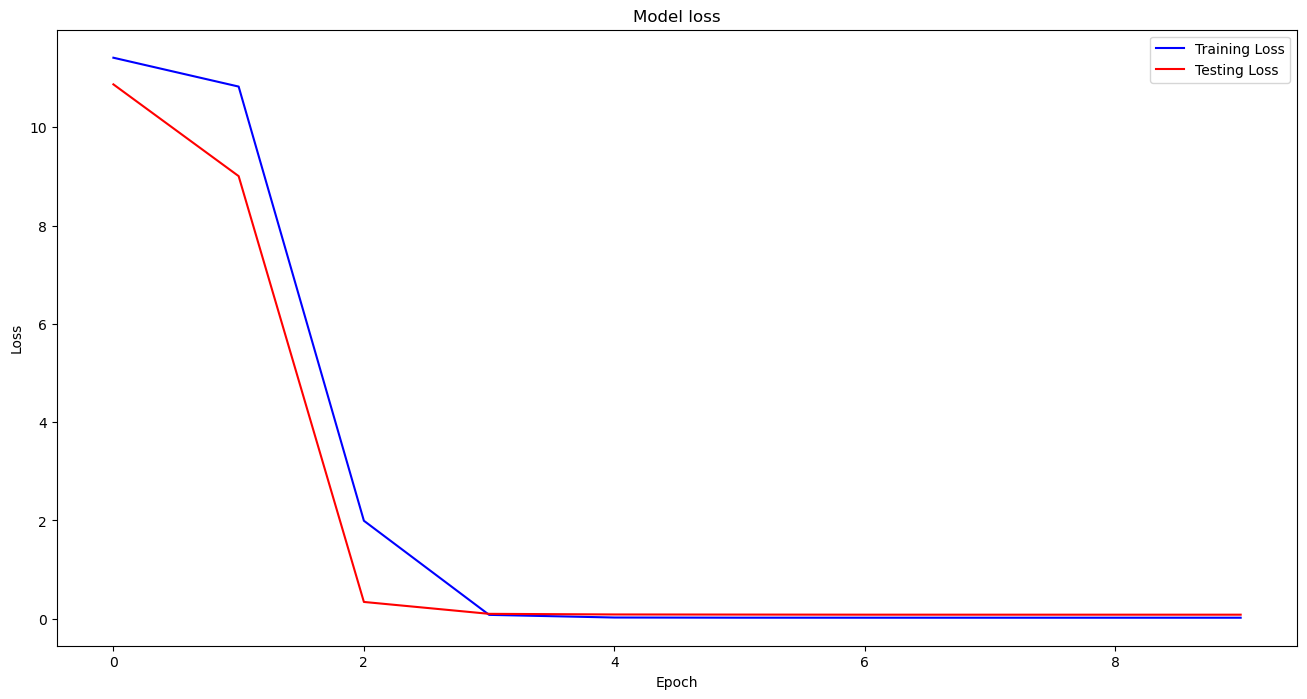

In [67]:
# Declares and initializes the model history 
history = model.history.history 

#Calls the plot function
plot_epoch_vs_train_test_loss_graph(history)

#From the graph below one can tell the model perfomed quite well on testing as the loss on training superceeded that on testing

In [76]:
# Function to calculate Word Error Rate (WER)
def calculate_wer(predictions, ground_truth):
    total_wer = 0.0
    total_words = 0
    for pred_seq, true_seq in zip(predictions, ground_truth):
        pred_str = ''.join([chr(c) + ' ' for c in pred_seq if c != 0]).strip()
        true_str = ''.join([chr(c) + ' ' for c in true_seq if c != 0]).strip()
        pred_words = pred_str.split()
        true_words = true_str.split()
        wer = lev.distance(pred_words, true_words) / max(len(true_words), 1)
        total_wer += wer
        total_words += len(true_words)
    return total_wer / len(ground_truth)

In [77]:
# Function to calculate Character Error Rate (CER)
def calculate_cer(predictions, ground_truth):
    total_cer = 0.0
    total_characters = 0
    for pred_seq, true_seq in zip(predictions, ground_truth):
        pred_str = ''.join([chr(c) + ' ' for c in pred_seq if c != 0]).strip()
        true_str = ''.join([chr(c) + ' ' for c in true_seq if c != 0]).strip()
        cer = lev.distance(pred_str, true_str) / max(len(true_str), 1)
        total_cer += cer
        total_characters += len(true_str)
    return total_cer / len(ground_truth)


Results:

- Test Loss: 0.0811464935541153 -> 8.11%
   
- Character Error Rate (CER): 0.009420768254554597 -> 0.94% -> Implies 0.94% of characters in the predicted transcriptions differ from the characters in the ground truth transcriptions.

- Word Error Rate (WER): 0.01706149887810178 -> 1.71% -> 1.71% of words in the predicted transcriptions differ from the words 
in the ground truth transcriptions.


The test loss value of 0.081 is relatively low, which generally indicates that the model performed well on the test data. However, this value should be further tested through further expermentation, e.g. expanding character sets, further augmentation, increasing sample size,
epochs or batch_size.

Regarding the Character Error Rate (CER: 0.009) and Word Error Rate (WER: 0.017), both returned low values, which suggests that the model is making few errors in character and word recognition. Again, this can also be tested with further experimentation similar to that mentioned in the paragraph above on the test loss value.

In [79]:
# Evaluate the model using the test data
loss = model.evaluate(x_test, y_test)

# Make predictions on the test data
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=-1)

# Calculate Character Error Rate (CER)
cer = calculate_cer(predictions, y_test)

# Calculate Word Error Rate (WER)
wer = calculate_wer(predictions, y_test)

print("Test Loss:", loss)
print("Character Error Rate (CER):", cer) 
print("Word Error Rate (WER):", wer)

13/13 [==============================] - 2s 146ms/step
Test Loss: 0.0811464935541153
Character Error Rate (CER): 0.009420768254554597
Word Error Rate (WER): 0.01706149887810178


In [88]:
#predicted value in normalized format
predictions[0]

array([21,  8,  9, 19,  9,  9,  1, 11,  2,  1, 22,  4, 26,  1, 63,  8,  9,
       19,  9,  9,  1,  7, 10, 19,  3, 17,  3, 19,  3,  1, 22, 10, 26,  1,
        7,  2,  1,  7,  2, 26,  2,  1, 15,  4,  1,  8, 13, 13, 11,  4,  1,
        7,  2,  1,  6,  1, 22,  2,  1,  7, 33,  6,  1, 15,  6,  1,  7, 33,
        6,  1, 16, 10, 19,  3,  1,  5, 10,  1, 17,  3,  4,  6,  1,  7,  2,
        1,  7,  2, 26,  2,  1, 12,  4, 26,  1, 17,  2,  5,  4,  1,  2,  1,
       63,  8,  9, 19,  9,  9,  1, 18,  2,  7,  4, 19,  4, 24,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [87]:
#ground truth or true value in normalized format
y_test[0]

array([21,  8,  9, 19,  9,  9,  1, 11,  2,  1, 22,  4, 26,  1, 60,  8,  9,
       19,  9,  9,  1,  7, 10, 19,  3, 17,  3, 19,  3,  1, 22, 10, 26,  1,
        7,  2,  1,  7,  2, 26,  2,  1, 15,  4,  1,  8, 13, 13, 11,  4,  1,
        7,  2,  1,  6,  1, 22,  2,  1,  7, 33,  6,  1, 15,  6,  1,  7, 33,
        6,  1, 16, 10, 19,  3,  1,  5, 10,  1, 17,  3,  4,  6,  1,  7,  2,
        1,  7,  2, 26,  2,  1, 12,  4, 26,  1, 17,  2,  5,  4,  1,  2,  1,
       60,  8,  9, 19,  9,  9,  1, 18,  2,  7,  4, 19,  4, 24,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [223]:
# Decodes y values from their normalized or coded format to human readable format for further analysis, It is
# easier to read or identify differenced between predicted values and true values in human readable format that in
# the normalized or coded format
def decode_label(prep_y_label, tokenizer):
    # Reverse the padding
    decoded_sequence = []
    for token in prep_y_label:
        if token != 0:  # Exclude padding token
            decoded_sequence.append(token)
        else:
            break  # Stop decoding at the first padding token
    
    # Convert sequence back into text
    decoded_text = tokenizer.sequences_to_texts([decoded_sequence])[0]
    
    return decoded_text

# 
decoded_y_test_values = decode_label(y_test[0], tokenizer)
print('Actual Transcription'+"\n"+ 
      '===================='+'\n'+decoded_y_test_values+ '\n')


decoded_predictions = decode_label(predictions[0], tokenizer)
print('Predicted Transcription'+"\n"+ 
      '======================='+'\n'+decoded_predictions+ '\n')

print('Raw state of Transcription with any form as collected/unformatted'+'\n'+
      '================================================================='+'\n'+ test_data['TRANSCRIPTION'].iloc[0])


Actual Transcription
g b ɛ r ɛ ɛ   l a   z e ŋ   ; b ɛ r ɛ ɛ   k u r i w i r i   z u ŋ   k a   k a ŋ a   d e   b ɔ ɔ l e   k a   o   z a   k ' o   d o   k ' o   t u r i   n u   w i e o   k a   k a ŋ a   m e ŋ   w a n e   a   ; b ɛ r ɛ ɛ   s a k e r e .

Predicted Transcription
g b ɛ r ɛ ɛ   l a   z e ŋ   ɡ b ɛ r ɛ ɛ   k u r i w i r i   z u ŋ   k a   k a ŋ a   d e   b ɔ ɔ l e   k a   o   z a   k ' o   d o   k ' o   t u r i   n u   w i e o   k a   k a ŋ a   m e ŋ   w a n e   a   ɡ b ɛ r ɛ ɛ   s a k e r e .

Raw state of Transcription with any form as collected/unformatted
Gbɛrɛɛ la zeŋ ɡbɛrɛɛ kuriwiri zuŋ ka kaŋa de bɔɔle ka o za k'o do k'o turi nu wieo ka kaŋa meŋ wane a ɡbɛrɛɛ sakere.


Calculating Accuracy in the conventional way with the nature of this project/problem is not appropriate as it gives 
farfetch or unfeasible results. As seen the results from the doing resulted in a value of 348.312 instead of a 
value between o and 1 were 1 represents 100%, Accuracy is best fitted for typical Classification problems where its it you are
predicts its an animal or object, not for problems such as this where interest of accuracy lies more on the character or word 
level.

In [204]:
# This cell compares ground truth values with predicted values

# Calculate the number of correct predictions
num_correct = np.sum(np.equal(predictions, y_test)) #np.equal will return false for values that are not equal, it is not case sensitive
total_samples = len(y_test)

# Calculate accuracy
accuracy = num_correct / total_samples
print("Accuracy:", accuracy)

Accuracy: 348.312661498708
